In [87]:
import os
import json
import gzip
import datetime as dt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [2]:
DATA_DIR = os.path.abspath(os.path.join('..','data'))

In [3]:
data_file = os.path.join(DATA_DIR, '2017-02-14_2019_08_09.json.gz')

In [4]:
infile = gzip.open(data_file, 'r')

In [5]:
d = json.load(infile)

In [6]:
d['activities-heart'][15]

{'dateTime': '2017-03-01',
 'value': {'customHeartRateZones': [],
  'heartRateZones': [{'caloriesOut': 2415,
    'max': 89,
    'min': 30,
    'minutes': 1362,
    'name': 'Out of Range'},
   {'caloriesOut': 65.75625,
    'max': 125,
    'min': 89,
    'minutes': 14,
    'name': 'Fat Burn'},
   {'caloriesOut': 180.99375,
    'max': 152,
    'min': 125,
    'minutes': 12,
    'name': 'Cardio'},
   {'caloriesOut': 180.8625,
    'max': 220,
    'min': 152,
    'minutes': 11,
    'name': 'Peak'}],
  'restingHeartRate': 51}}

In [7]:
def fitbit_dict_to_dataframe(d):
    e = d['activities-heart']
    dates = []
    calories, minutes = {}, {}
    for k in ('normal', 'fat_burn', 'cardio', 'peak'):
        calories[k] = []
        minutes[k] = []
    heart_rates = []
    for item in e:
        f = item['value']
        if 'restingHeartRate' not in f:
            continue
        dates.append(item['dateTime'])
        for item2, k in zip(f['heartRateZones'], ('normal', 'fat_burn', 'cardio', 'peak')):
            calories[k].append(item2['caloriesOut'])
            minutes[k].append(item2['minutes'])
        heart_rates.append(f['restingHeartRate'])
    all_data = {'date': dates, 'heart_rate': heart_rates}
    all_data.update({f'calories_{k}': v for k, v in calories.items()})
    all_data.update({f'minutes_{k}': v for k, v in minutes.items()})
    df = pd.DataFrame(all_data)
    df['date'] = pd.to_datetime(df['date'])
    return df
            

In [99]:
e = fitbit_dict_to_dataframe(d)

In [100]:
missing_dates = [pd.to_datetime(y) for y in
                 set(str(x) for x in pd.date_range(e['date'][0], e['date'][len(e)-1]))
                 - set(str(x) for x in e['date'])
                ]
e2 = e.iloc[:len(missing_dates)].copy()
for k in e2.keys():
    e2[k] = None
e2['date'] = missing_dates
e3 = pd.concat([e, e2], ignore_index=True)
e = e3.sort_values(by='date')
e['heart_rate'] = e['heart_rate'].fillna(0)

In [101]:
e['week'] = e['date'] - pd.to_timedelta(e['date'].dt.dayofweek, unit='d')

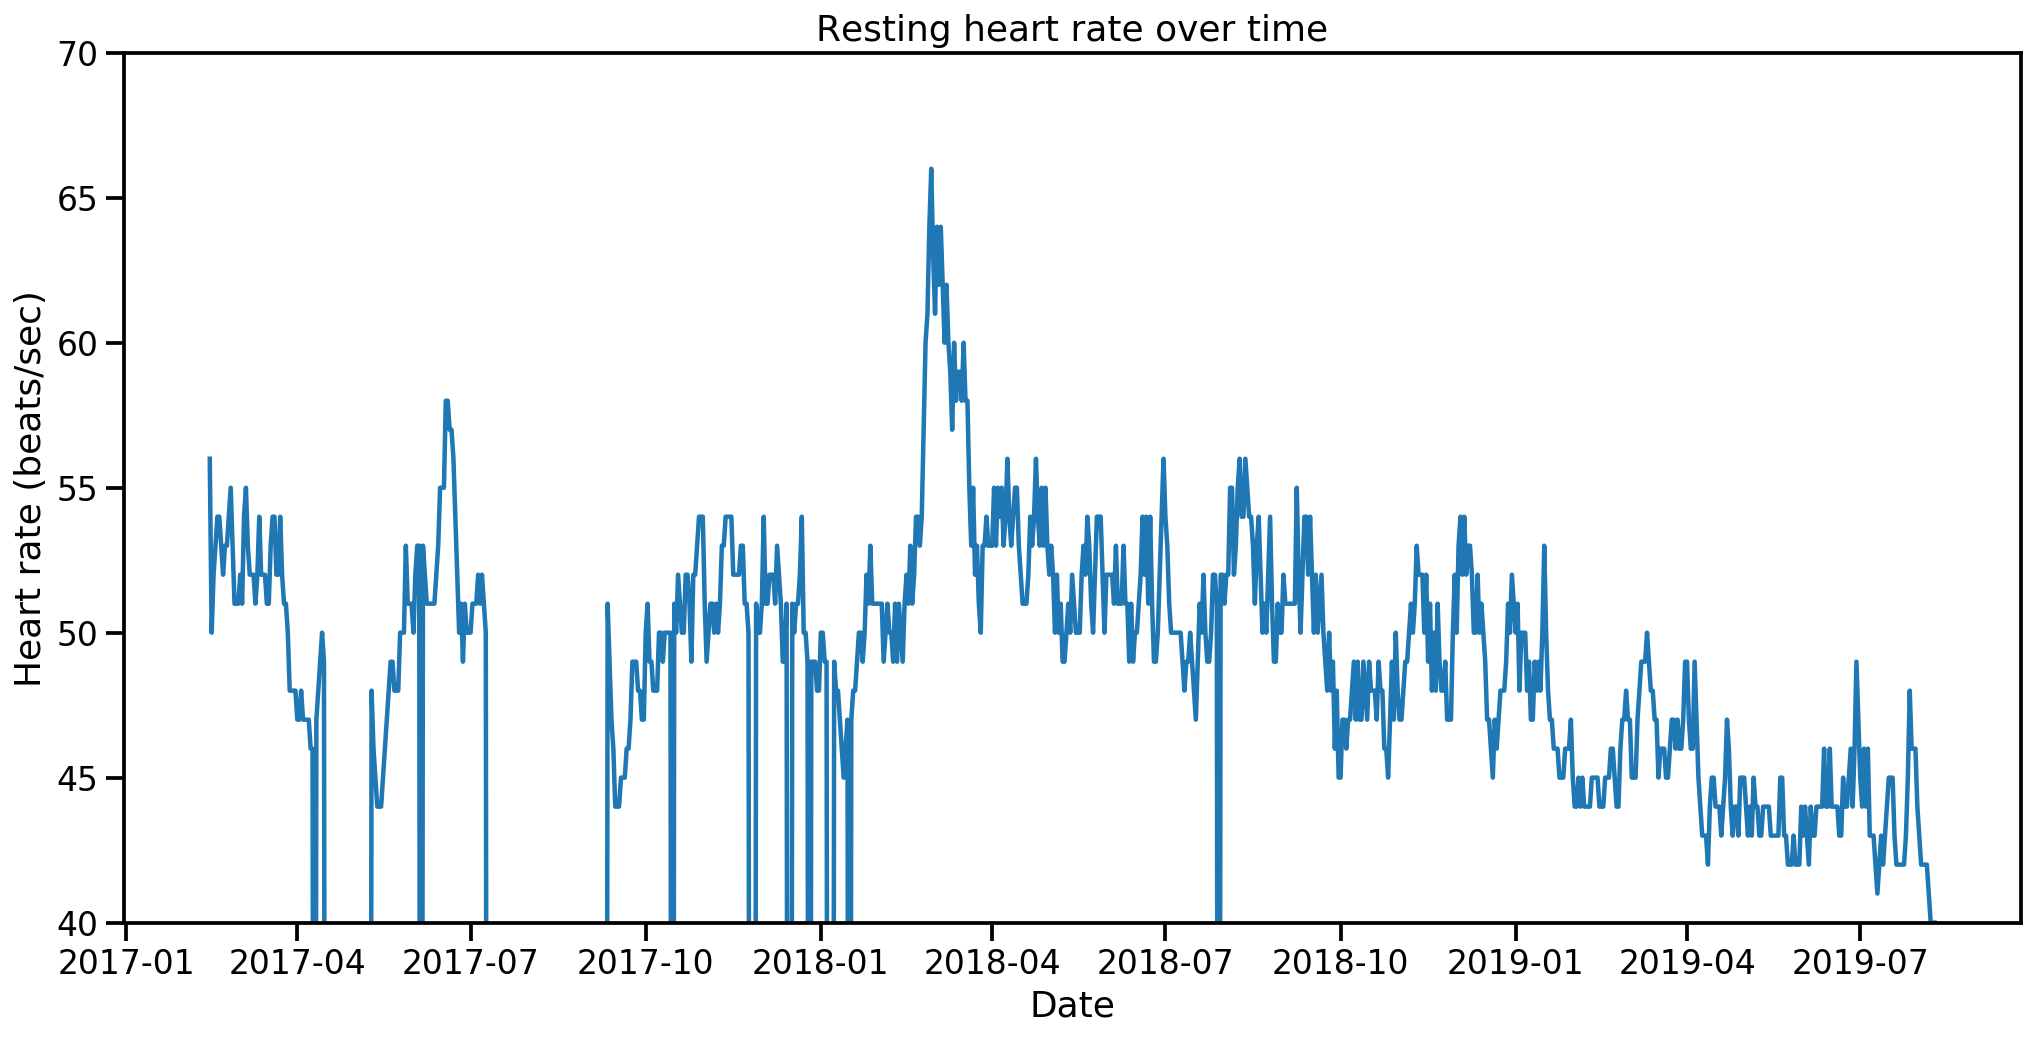

In [102]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(17,8))
sns.lineplot(e['date'], e['heart_rate'])
ax.set_ylim([40,70])
ax.set_ylabel('Heart rate (beats/sec)')
ax.set_xlabel('Date')
ax.set_title('Resting heart rate over time');

In [11]:
e['calories_total'] = e['calories_cardio'] + e['calories_fat_burn'] + e['calories_normal'] + e['calories_peak']

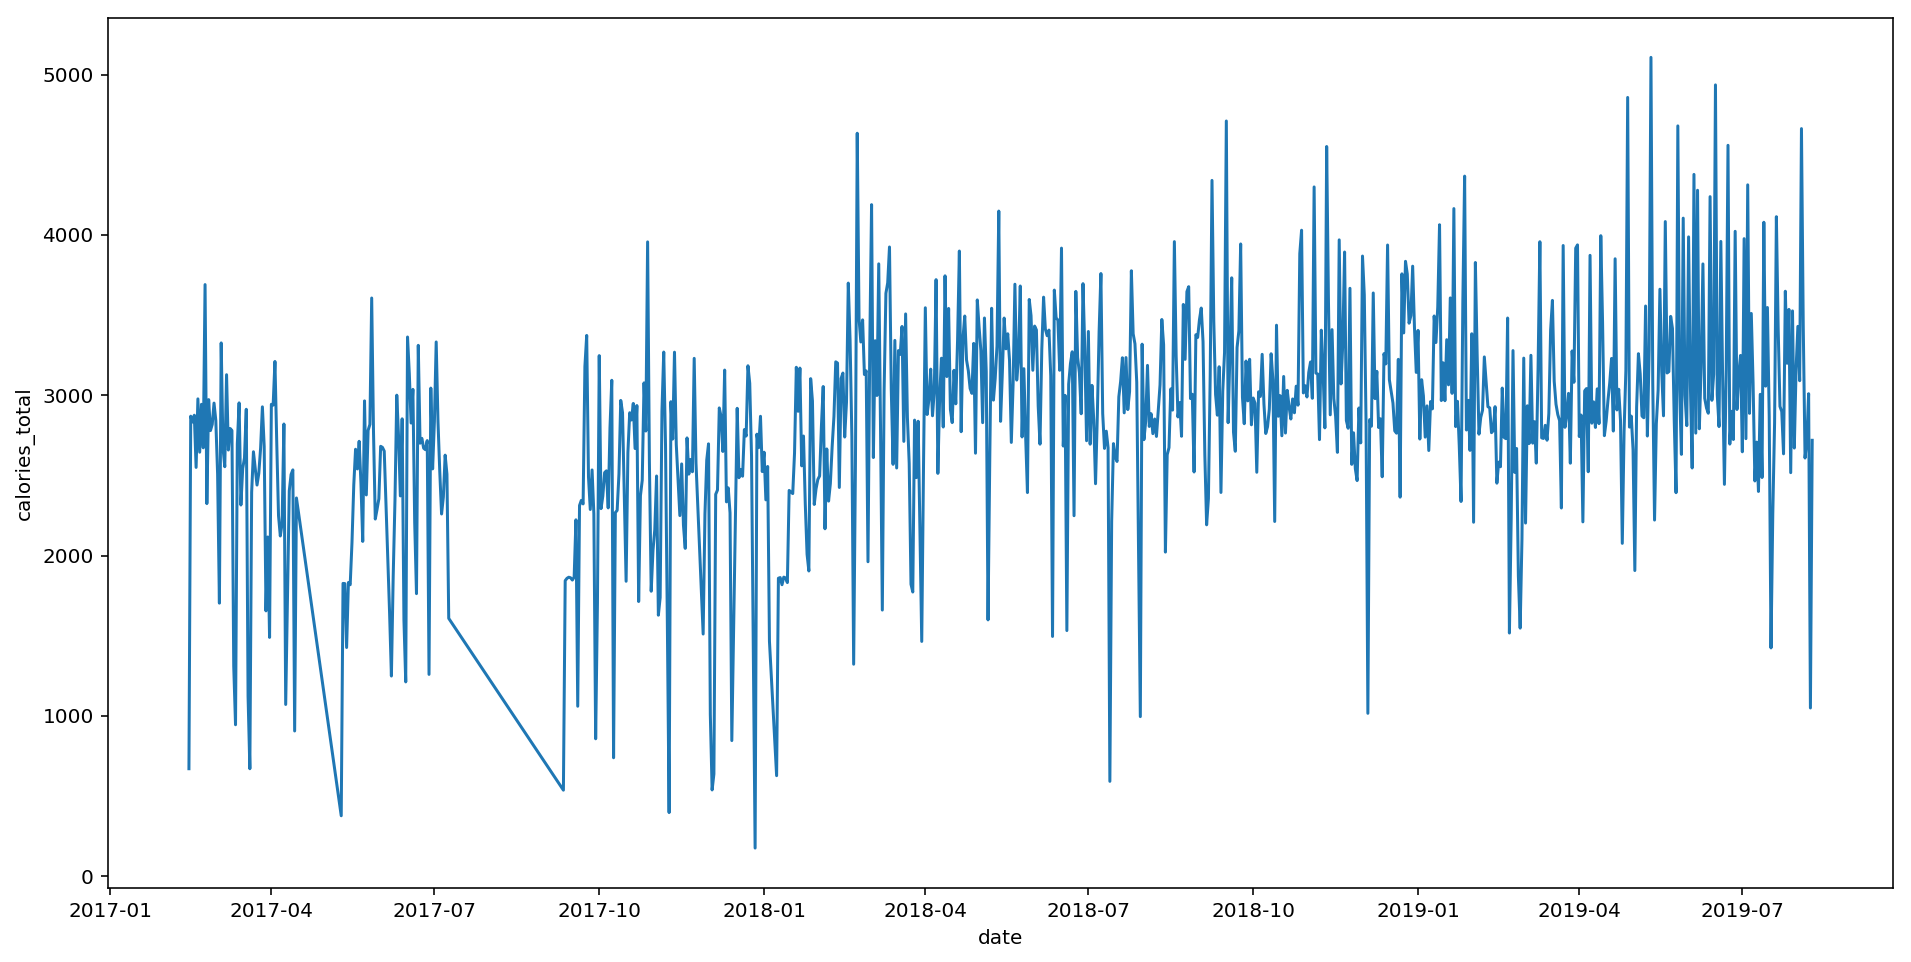

In [12]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(e['date'], e['calories_total'])

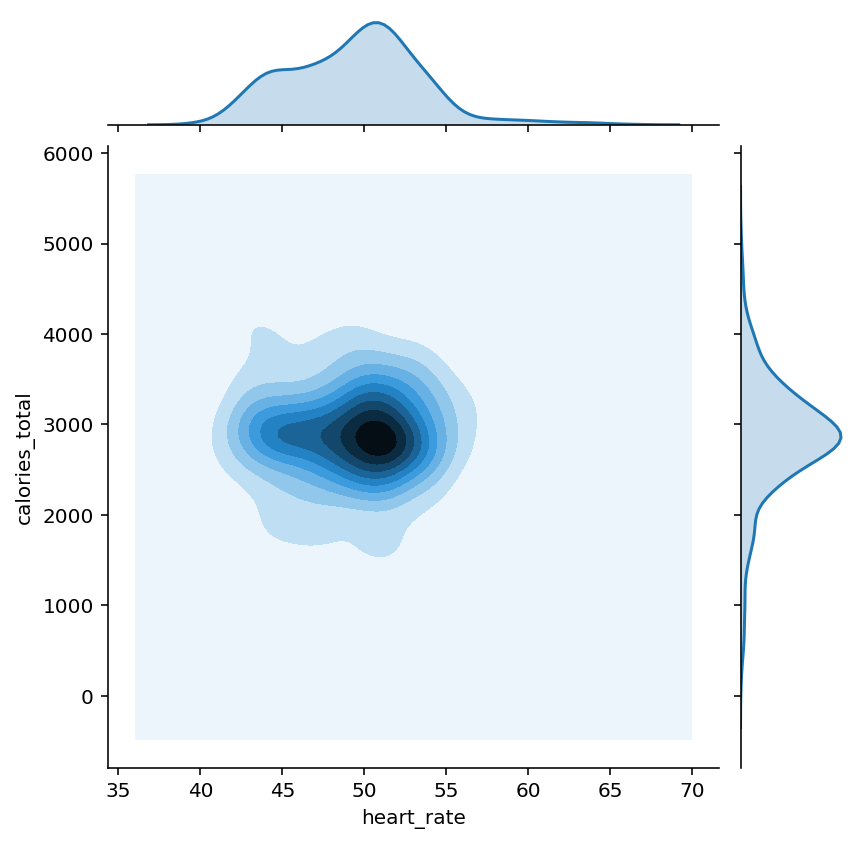

In [13]:
sns.jointplot(e['heart_rate'],e['calories_total'], kind='kde')

/Users/jon/projects/hrsync/ve/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


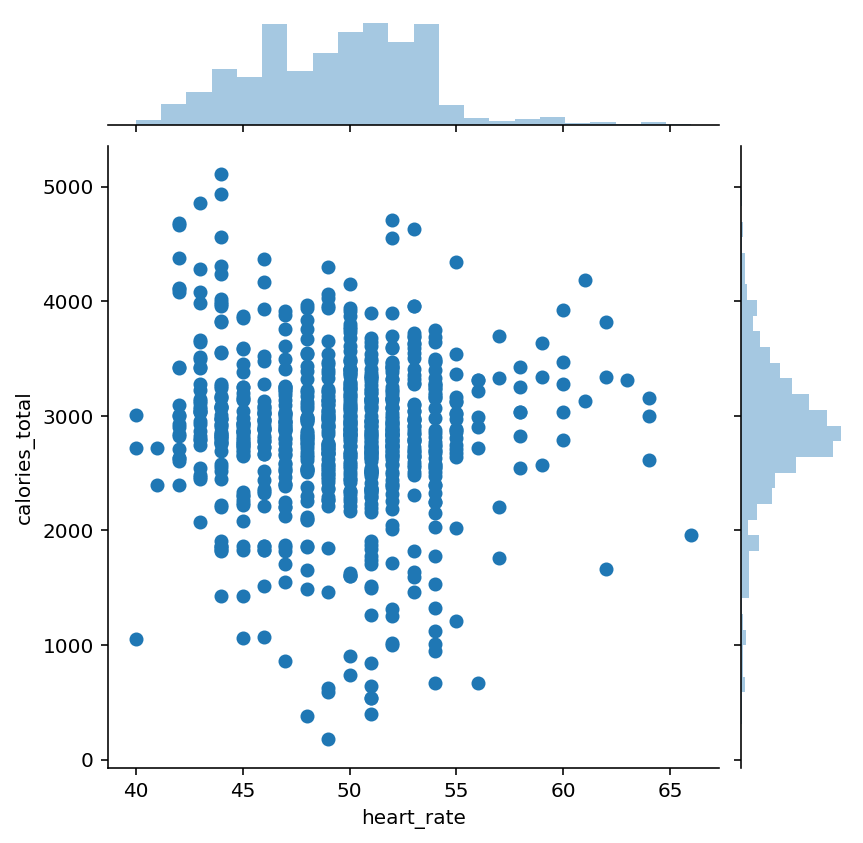

In [14]:
sns.jointplot(e['heart_rate'],e['calories_total'])